In [ ]:
!ls ../input

# COMP4651 Project — Kaggle competition https://www.kaggle.com/c/ga-customer-revenue-prediction/overview
### - Data collected from https://www.kaggle.com/qnkhuat/make-data-ready/code
### - Those data are already cleaned!!!
### - Please read the code within the website to understand what is cleaned and processed!!!

In [8]:
import numpy as np
import pandas as pd
import sys
import os
import os.path as osp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

sns.set()

%matplotlib inline

In [9]:
train_data = None
test_data = None

for i in range(9):
    if i == 0:
        train_data = pd.read_pickle(osp.join("..", "input", "make-data-ready", "train_"+str(i)+".pkl"))
        continue
    else:
        temp = pd.read_pickle(osp.join("..", "input", "make-data-ready", "train_"+str(i)+".pkl"))
        train_data = pd.concat([train_data, temp], ignore_index=True)

for j in range(3):
    if j == 0:
        test_data = pd.read_pickle(osp.join("..", "input", "make-data-ready", "test_"+str(j)+".pkl"))
        continue
    else:
        temp = pd.read_pickle(osp.join("..", "input", "make-data-ready", "test_"+str(j)+".pkl"))
        test_data = pd.concat([test_data, temp], ignore_index=True)
    


In [10]:
print(type(train_data))
print(type(test_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [11]:
print(train_data.columns)

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
       'totals_timeOnSite', 'totals_totalTransactionRevenue',
       'totals_transactionRevenue', 'totals_transactions', 'totals_visits',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       '

653534     2.312950e+10
764560     1.785550e+10
668147     1.602375e+10
1020100    1.322940e+10
810066     1.229300e+10
1449340    1.058914e+10
1316657    9.925110e+09
1693239    8.677830e+09
1349475    8.248800e+09
270728     7.427430e+09
Name: totals_transactionRevenue, dtype: float64 

1135634    0.0
1135635    0.0
1135636    0.0
1135637    0.0
1135638    0.0
1135639    0.0
1135640    0.0
1135641    0.0
1135642    0.0
0          0.0
Name: totals_transactionRevenue, dtype: float64 

count    1.708337e+06
mean     1.355906e+06
std      4.522809e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: totals_transactionRevenue, dtype: float64 



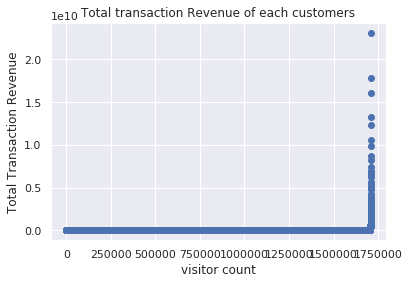

In [23]:
sorted_revenue = train_data['totals_transactionRevenue'].sort_values(ascending=False)
top_10_revenue = sorted_revenue.head(10)
least_10_revenue = sorted_revenue.tail(10)

print(top_10_revenue, '\n')
print(least_10_revenue, '\n')
print(sorted_revenue.describe(), '\n')

# train_data.plot.scatter(x='visitId', y='totals_transactionRevenue')
plt.scatter(x=range(len(sorted_revenue)), y=sorted_revenue.sort_values(ascending=True))

plt.title("Total transaction Revenue of each customers")
plt.xlabel("visitor count")
plt.ylabel("Total Transaction Revenue")

plt.show()

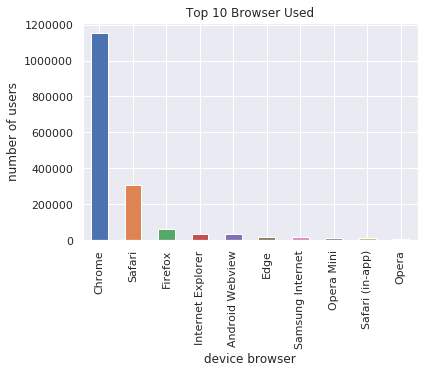

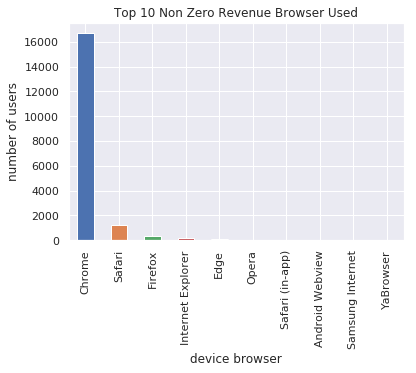

In [24]:
Top10_browser_used = train_data.groupby('device_browser')['visitId'].nunique().sort_values(ascending=False).head(10)
Top10_browser_used.plot.bar()

plt.title("Top 10 Browser Used")
plt.xlabel("device browser")
plt.ylabel("number of users")

plt.show()

Top10_nonzero_revenue_browser_used = train_data[train_data.totals_transactionRevenue>0].groupby('device_browser')['visitId'].nunique().sort_values(ascending=False).head(10)

Top10_nonzero_revenue_browser_used.plot.bar()

plt.title("Top 10 Non Zero Revenue Browser Used")
plt.xlabel("device browser")
plt.ylabel("number of users")

plt.show()

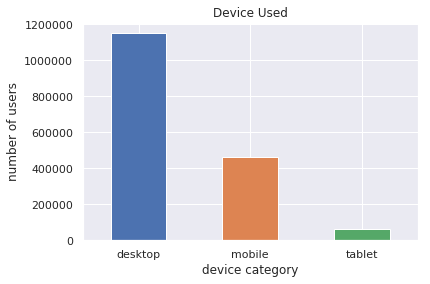

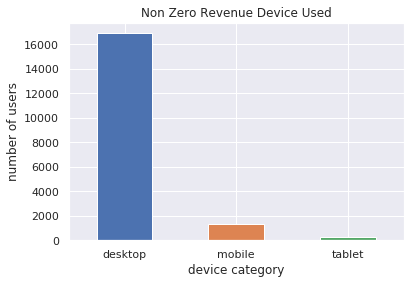

In [25]:
Device_used = train_data.groupby('device_deviceCategory')['visitId'].nunique().sort_values(ascending=False).head(10)

Device_used.plot.bar()

plt.title("Device Used")
plt.xlabel("device category")
plt.ylabel("number of users")

plt.xticks(rotation=0)

plt.show()

Nonzero_revenue_device_used = train_data[train_data.totals_transactionRevenue>0].groupby('device_deviceCategory')['visitId'].nunique().sort_values(ascending=False).head(10)

Nonzero_revenue_device_used.plot.bar()

plt.title("Non Zero Revenue Device Used")
plt.xlabel("device category")
plt.ylabel("number of users")

plt.xticks(rotation=0)

plt.show()

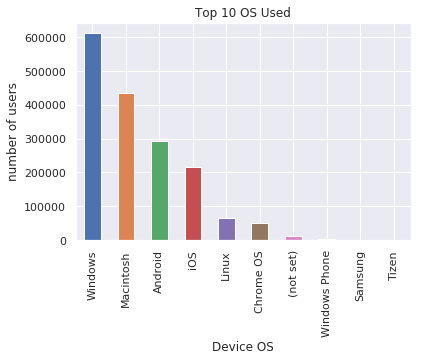

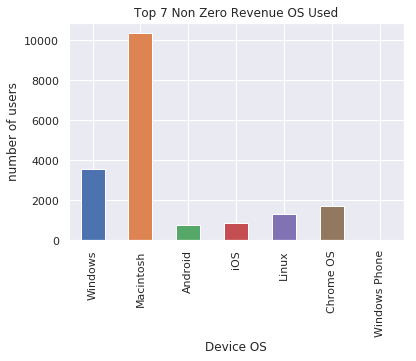

In [26]:
Top10_OS_used = train_data.groupby('device_operatingSystem')['visitId'].nunique().sort_values(ascending=False).head(10)

Top10_OS_used.plot.bar()

plt.title("Top 10 OS Used")
plt.xlabel("Device OS")
plt.ylabel("number of users")

plt.show()

Top10_nonzero_revenue_OS_used = train_data[train_data.totals_transactionRevenue>0].groupby('device_operatingSystem')['visitId'].nunique().sort_values(ascending=False).head(10)


new_index = ['Windows', 'Macintosh',  'Android', 'iOS', 'Linux', 'Chrome OS', 'Windows Phone']

Top10_nonzero_revenue_OS_used = Top10_nonzero_revenue_OS_used.reindex(new_index)

Top10_nonzero_revenue_OS_used.plot.bar()

plt.title("Top 7 Non Zero Revenue OS Used")
plt.xlabel("Device OS")
plt.ylabel("number of users")

plt.show()

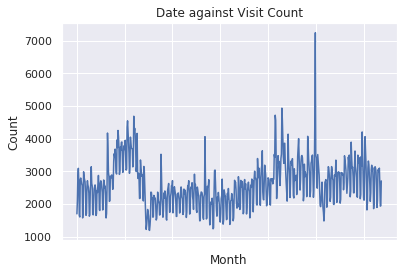

In [27]:
import matplotlib.pyplot as plt

Date_against_visitcount = train_data.groupby(['Date_Year', 'Date_Month', 'Date_Day'])['visitId'].nunique()

Date_against_visitcount.plot()

plt.title("Date against Visit Count")
plt.xlabel("Month")
plt.ylabel("Count")


plt.show()

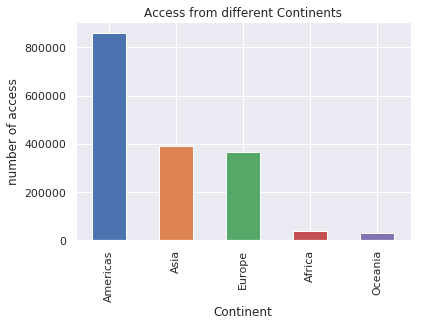

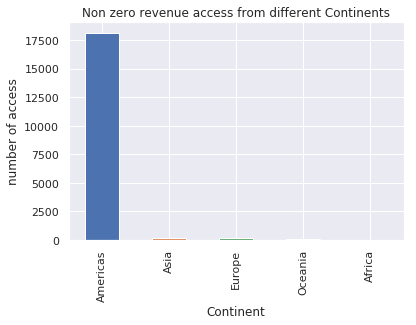

In [28]:
continent = train_data.groupby('geoNetwork_continent')['visitId'].nunique().sort_values(ascending=False).head(5)

continent.plot.bar()

plt.title("Access from different Continents")
plt.xlabel("Continent")
plt.ylabel("number of access")

plt.show()

continent_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('geoNetwork_continent')['visitId'].nunique().sort_values(ascending=False).head(5)

continent_nonzero_revenue.plot.bar()

plt.title("Non zero revenue access from different Continents")
plt.xlabel("Continent")
plt.ylabel("number of access")

plt.show()

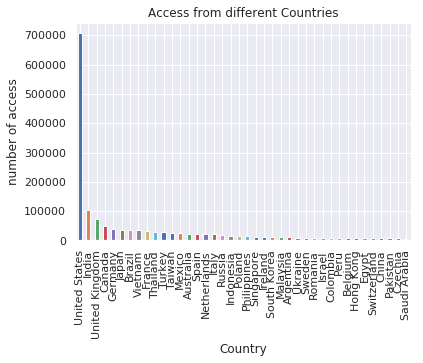

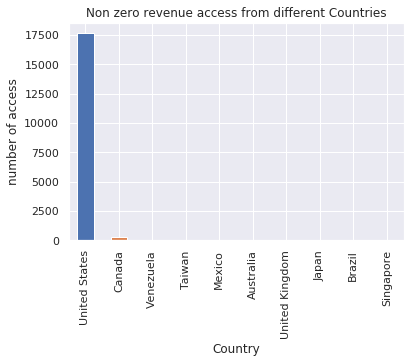

In [29]:
country = train_data.groupby('geoNetwork_country')['visitId'].nunique().sort_values(ascending=False).head(40)

country.plot.bar()

plt.title("Access from different Countries")
plt.xlabel("Country")
plt.ylabel("number of access")

plt.show()

country_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('geoNetwork_country')['visitId'].nunique().sort_values(ascending=False).head(10)

country_nonzero_revenue.plot.bar()

plt.title("Non zero revenue access from different Countries")
plt.xlabel("Country")
plt.ylabel("number of access")

plt.show()

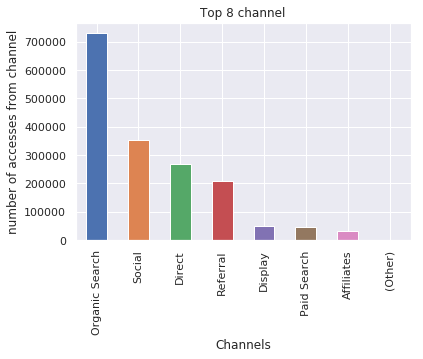

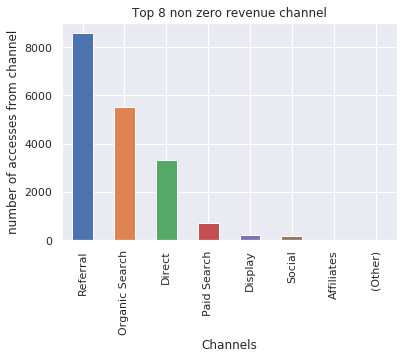

In [30]:
Top8_channel = train_data.groupby('channelGrouping')['visitId'].nunique().sort_values(ascending=False).head(10)
Top8_channel.plot.bar()

plt.title("Top 8 channel")
plt.xlabel("Channels")
plt.ylabel("number of accesses from channel")

plt.show()

Top8_channel_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('channelGrouping')['visitId'].nunique().sort_values(ascending=False).head(10)
Top8_channel_nonzero_revenue.plot.bar()

plt.title("Top 8 non zero revenue channel")
plt.xlabel("Channels")
plt.ylabel("number of accesses from channel")

plt.show()

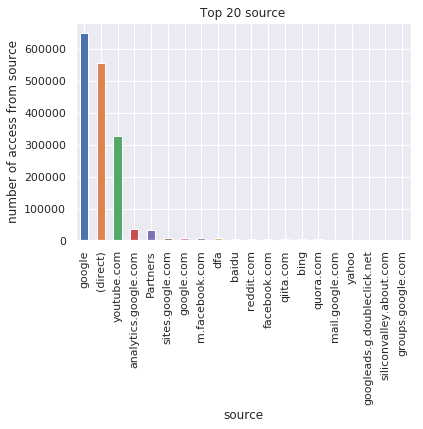

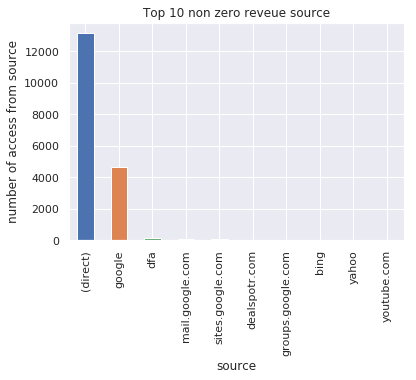

In [31]:
Top20_source = train_data.groupby('trafficSource_source')['visitId'].nunique().sort_values(ascending=False).head(20)
Top20_source.plot.bar()

plt.title("Top 20 source")
plt.xlabel("source")
plt.ylabel("number of access from source")


plt.show()

Top10_source_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('trafficSource_source')['visitId'].nunique().sort_values(ascending=False).head(10)
Top10_source_nonzero_revenue.plot.bar()

plt.title("Top 10 non zero reveue source")
plt.xlabel("source")
plt.ylabel("number of access from source")


plt.show()

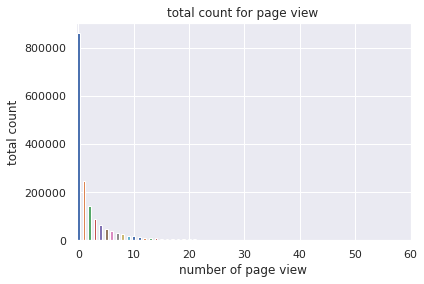

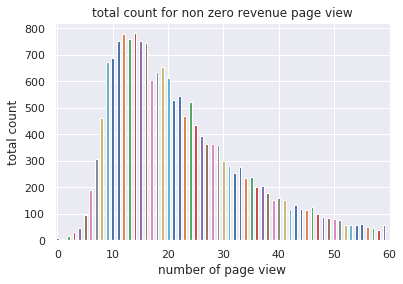

In [32]:
total_pageview = train_data.groupby('totals_pageviews')['visitId'].nunique().sort_values(ascending=False).head(60)
total_pageview.plot.bar()

plt.title("total count for page view")
plt.xlabel("number of page view")
plt.ylabel("total count")

plt.xticks(range(0,61, 10), range(0,61, 10), rotation=0) # ticks = ..., labels = ...


plt.show()

total_pageview_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('totals_pageviews')['visitId'].nunique().head(60)
total_pageview_nonzero_revenue.plot.bar()

plt.title("total count for non zero revenue page view")
plt.xlabel("number of page view")
plt.ylabel("total count")

plt.xticks(range(0,61, 10), range(0,61, 10), rotation=0) # ticks = ..., labels = ...

plt.show()

In [12]:
test_id = test_data["fullVisitorId"].values
X_train= train_data.drop(columns=['totals_totalTransactionRevenue', 'totals_transactionRevenue']).apply(lambda x: pd.factorize(x)[0])
y_train = train_data['totals_transactionRevenue'].apply(lambda x: np.log1p(x))
X_test = test_data.drop(columns=['totals_totalTransactionRevenue', 'totals_transactionRevenue']).apply(lambda x: pd.factorize(x)[0])
y_test = test_data['totals_transactionRevenue'].apply(lambda x: np.log1p(x))


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1708337, 52) (1708337,)
(401589, 52) (401589,)


In [18]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
min = 100
for i in range(5):
    num_leaves = np.random.random_integers(10)*20
    max_depth = np.random.random_integers(10)
    learning_rate = 10**np.random.uniform(-3,-1)
    evals_result = {}
    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'rmse'},
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'max_bin': 255,
        'learning_rate': learning_rate,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'bagging_freq': 5,
        'verbose': 0
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=5000,
                    valid_sets=[lgb_train, lgb_eval],
                    early_stopping_rounds=100,
                    verbose_eval=50,
                    evals_result=evals_result)

    print('Starting predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    # eval
    print("num_leaves=",num_leaves)
    print("max_depth=",max_depth)
    print("learning_rate=",learning_rate)
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    if(mean_squared_error(y_test, y_pred) ** 0.5 < min):
        min = mean_squared_error(y_test, y_pred) ** 0.5
        print('Saving model...')
        # save model to file
        gbm.save_model('model.txt')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  


Starting training...
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 1.29583	valid_1's rmse: 1.4394
[100]	training's rmse: 1.00845	valid_1's rmse: 1.34039
[150]	training's rmse: 0.754107	valid_1's rmse: 1.21754
[200]	training's rmse: 0.583487	valid_1's rmse: 1.14328
[250]	training's rmse: 0.436588	valid_1's rmse: 1.10898
[300]	training's rmse: 0.337347	valid_1's rmse: 1.09067
[350]	training's rmse: 0.281025	valid_1's rmse: 1.08406
[400]	training's rmse: 0.243574	valid_1's rmse: 1.08189
[450]	training's rmse: 0.209416	valid_1's rmse: 1.08506
Early stopping, best iteration is:
[397]	training's rmse: 0.24612	valid_1's rmse: 1.08053
Starting predicting...
num_leaves= 180
max_depth= 3
learning_rate= 0.010415344207074628
The rmse of prediction is: 1.0805314513431425
Saving model...
Starting training...
Training until validation scores don't improve for 100 rounds.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  


[50]	training's rmse: 1.48825	valid_1's rmse: 1.58849
[100]	training's rmse: 1.26763	valid_1's rmse: 1.44296
[150]	training's rmse: 1.054	valid_1's rmse: 1.2909
[200]	training's rmse: 0.891688	valid_1's rmse: 1.1885
[250]	training's rmse: 0.734055	valid_1's rmse: 1.10796
[300]	training's rmse: 0.608653	valid_1's rmse: 1.0594
[350]	training's rmse: 0.523575	valid_1's rmse: 1.04273
[400]	training's rmse: 0.457476	valid_1's rmse: 1.03234
[450]	training's rmse: 0.386535	valid_1's rmse: 1.02783
[500]	training's rmse: 0.339165	valid_1's rmse: 1.03087
[550]	training's rmse: 0.296709	valid_1's rmse: 1.03633
Early stopping, best iteration is:
[457]	training's rmse: 0.376646	valid_1's rmse: 1.02731
Starting predicting...
num_leaves= 200
max_depth= 10
learning_rate= 0.006066183525270003
The rmse of prediction is: 1.0273130913028872
Saving model...
Starting training...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  


Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 1.64518	valid_1's rmse: 1.7146
[100]	training's rmse: 1.51105	valid_1's rmse: 1.6253
[150]	training's rmse: 1.36666	valid_1's rmse: 1.52636
[200]	training's rmse: 1.24587	valid_1's rmse: 1.44658
[250]	training's rmse: 1.11634	valid_1's rmse: 1.36428
[300]	training's rmse: 1.00245	valid_1's rmse: 1.296
[350]	training's rmse: 0.917382	valid_1's rmse: 1.2619
[400]	training's rmse: 0.845501	valid_1's rmse: 1.2364
[450]	training's rmse: 0.762327	valid_1's rmse: 1.19939
[500]	training's rmse: 0.700711	valid_1's rmse: 1.18075
[550]	training's rmse: 0.641184	valid_1's rmse: 1.15599
[600]	training's rmse: 0.587686	valid_1's rmse: 1.13857
[650]	training's rmse: 0.538539	valid_1's rmse: 1.12429
[700]	training's rmse: 0.493077	valid_1's rmse: 1.11052
[750]	training's rmse: 0.463983	valid_1's rmse: 1.10772
[800]	training's rmse: 0.428819	valid_1's rmse: 1.09935
[850]	training's rmse: 0.398382	valid_1's rmse: 1.0923

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  


[50]	training's rmse: 1.69654	valid_1's rmse: 1.75657
[100]	training's rmse: 1.59495	valid_1's rmse: 1.6759
[150]	training's rmse: 1.4816	valid_1's rmse: 1.58925
[200]	training's rmse: 1.38422	valid_1's rmse: 1.52023
[250]	training's rmse: 1.27614	valid_1's rmse: 1.44578
[300]	training's rmse: 1.17798	valid_1's rmse: 1.38167
[350]	training's rmse: 1.10242	valid_1's rmse: 1.34566
[400]	training's rmse: 1.03687	valid_1's rmse: 1.32358
[450]	training's rmse: 0.958931	valid_1's rmse: 1.28535
[500]	training's rmse: 0.899283	valid_1's rmse: 1.26562
[550]	training's rmse: 0.840337	valid_1's rmse: 1.24689
[600]	training's rmse: 0.785802	valid_1's rmse: 1.23511
[650]	training's rmse: 0.734238	valid_1's rmse: 1.22092
[700]	training's rmse: 0.685128	valid_1's rmse: 1.20641
[750]	training's rmse: 0.652604	valid_1's rmse: 1.20444
[800]	training's rmse: 0.6126	valid_1's rmse: 1.19225
[850]	training's rmse: 0.576955	valid_1's rmse: 1.18399
[900]	training's rmse: 0.549761	valid_1's rmse: 1.18207
[950]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  


[50]	training's rmse: 1.08944	valid_1's rmse: 1.29054
[100]	training's rmse: 0.75771	valid_1's rmse: 1.14358
[150]	training's rmse: 0.504845	valid_1's rmse: 1.03638
[200]	training's rmse: 0.359252	valid_1's rmse: 1.01787
[250]	training's rmse: 0.253774	valid_1's rmse: 1.03803
Early stopping, best iteration is:
[199]	training's rmse: 0.363741	valid_1's rmse: 1.01728
Starting predicting...
num_leaves= 40
max_depth= 7
learning_rate= 0.015247742458252198
The rmse of prediction is: 1.0172758664966177
Saving model...


In [33]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
y_pred[y_pred<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(y_pred)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df.to_csv("submission.csv", index=False)

In [34]:
sub_df.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.612052
1,0000039738481224681,0.759142
2,0000073585230191399,0.763664
3,0000087588448856385,0.640178
4,0000149787903119437,0.622669
5,0000196310838896290,0.616577
6,00001995526696366,0.609630
7,0000255704530917106,0.716027
8,0000268499301061358,0.629250
9,0000276747989270229,0.684693


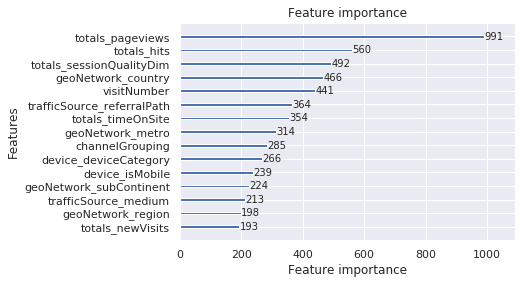

In [35]:
lgb.plot_importance(gbm, max_num_features=15)

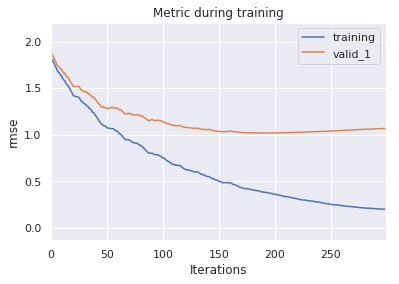

In [ ]:
lgb.plot_metric(evals_result, metric='rmse')

In [20]:
from sklearn.ensemble import RandomForestClassifier

min = 100
max = 0
for i in range(5):
    max_depth = np.random.random_integers(40)
    clf = RandomForestClassifier(n_estimators=50, max_depth=max_depth,random_state=0)
    clf.fit(X_train.values, y_train.values.astype('int'))
    y_pred = clf.predict(X_test)
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    
    if(mean_squared_error(y_test, y_pred) ** 0.5<min):
        min = mean_squared_error(y_test, y_pred) ** 0.5
        max = max_depth
        print("the best max_depth=",max)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 40 + 1) instead
  


The rmse of prediction is: 0.977092448564124
the best max_depth= 22


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 40 + 1) instead
  


The rmse of prediction is: 0.9691451907888972
the best max_depth= 39


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 40 + 1) instead
  


The rmse of prediction is: 0.9882813799491613


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 40 + 1) instead
  


The rmse of prediction is: 1.0736139075886733


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(1, 40 + 1) instead
  


The rmse of prediction is: 0.9575790856466814
the best max_depth= 30


In [22]:
import xgboost as xgb

min = 100
for i in range(5):
    max_depth = np.random.random_integers(20)
    lr = 10**np.random.uniform(-4,-1)
    params = {'objective': 'reg:linear',
                  'eval_metric': 'rmse',
                  'eta': 0.001,
                  'max_depth': max_depth,
                  'subsample': 0.6,
                  'colsample_bytree': 0.6,
                  'alpha':lr,
                  'random_state': 42,
                  'silent': True}


    #gbm = xgb.XGBClassifier(max_depth=6, n_estimators=300, learning_rate=0.05)\
      #  .fit(X_train.values, y_train.values.astype('int'))
    #y_pred = gbm.predict(test_X)

    xgb_train_data = xgb.DMatrix(X_train[:1366669], y_train[:1366669])
    xgb_val_data = xgb.DMatrix(X_train[1366669:], y_train[1366669:])
    xgb_submit_data = xgb.DMatrix(X_test)

    model = xgb.train(params, xgb_train_data, 
                          num_boost_round=50, 
                          evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                          early_stopping_rounds=5, 
                          verbose_eval=10
                         )

    y_pred = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    
    if(min>mean_squared_error(y_test, y_pred) ** 0.5):
        min = mean_squared_error(y_test, y_pred) ** 0.5
        print("max_depth=", max_depth)
        print("alpha=",lr)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 20 + 1) instead
  """


[0]	train-rmse:1.87017	valid-rmse:1.85752
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[10]	train-rmse:1.85269	valid-rmse:1.8405
[20]	train-rmse:1.83743	valid-rmse:1.82631
[30]	train-rmse:1.82364	valid-rmse:1.81379
[40]	train-rmse:1.81134	valid-rmse:1.80288
[49]	train-rmse:1.80016	valid-rmse:1.79328
The rmse of prediction is: 1.8594662813427636
max_depth= 16
alpha= 0.0016911637834233623


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 20 + 1) instead
  """


[0]	train-rmse:1.87017	valid-rmse:1.85752
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[10]	train-rmse:1.85265	valid-rmse:1.84052
[20]	train-rmse:1.83727	valid-rmse:1.82636
[30]	train-rmse:1.82329	valid-rmse:1.81387
[40]	train-rmse:1.8108	valid-rmse:1.80299
[49]	train-rmse:1.79941	valid-rmse:1.79345
The rmse of prediction is: 1.8594978979293002


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 20 + 1) instead
  """


[0]	train-rmse:1.87017	valid-rmse:1.85752
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[10]	train-rmse:1.85321	valid-rmse:1.84067
[20]	train-rmse:1.83953	valid-rmse:1.82707
[30]	train-rmse:1.82774	valid-rmse:1.81535
[40]	train-rmse:1.81762	valid-rmse:1.80529
[49]	train-rmse:1.80903	valid-rmse:1.79674
The rmse of prediction is: 1.86218793887654


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 20 + 1) instead
  """


[0]	train-rmse:1.87017	valid-rmse:1.85752
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[10]	train-rmse:1.8529	valid-rmse:1.84037
[20]	train-rmse:1.83834	valid-rmse:1.82604
[30]	train-rmse:1.82547	valid-rmse:1.81341
[40]	train-rmse:1.81415	valid-rmse:1.80228
[49]	train-rmse:1.80411	valid-rmse:1.79248
The rmse of prediction is: 1.8595937818193164


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. Please call randint(1, 20 + 1) instead
  """


[0]	train-rmse:1.87017	valid-rmse:1.85752
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[10]	train-rmse:1.85292	valid-rmse:1.84039
[20]	train-rmse:1.83844	valid-rmse:1.82605
[30]	train-rmse:1.82565	valid-rmse:1.81348
[40]	train-rmse:1.81442	valid-rmse:1.80238
[49]	train-rmse:1.8045	valid-rmse:1.79261
The rmse of prediction is: 1.8594769978511567
